In [1]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from pymongo import MongoClient
import numpy as np
from ndlibCustom.SEIR_ASModel import SEIR_ASModel
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import seaborn as sns
import scipy.stats as st

1229994
9032197


In [ ]:
G = nx.read_gpickle('Datasets/dataset.gpickle')
relabeled = nx.convert_node_labels_to_integers(G)
del(G)
print(len(relabeled.nodes()))
print(len(relabeled.edges()))

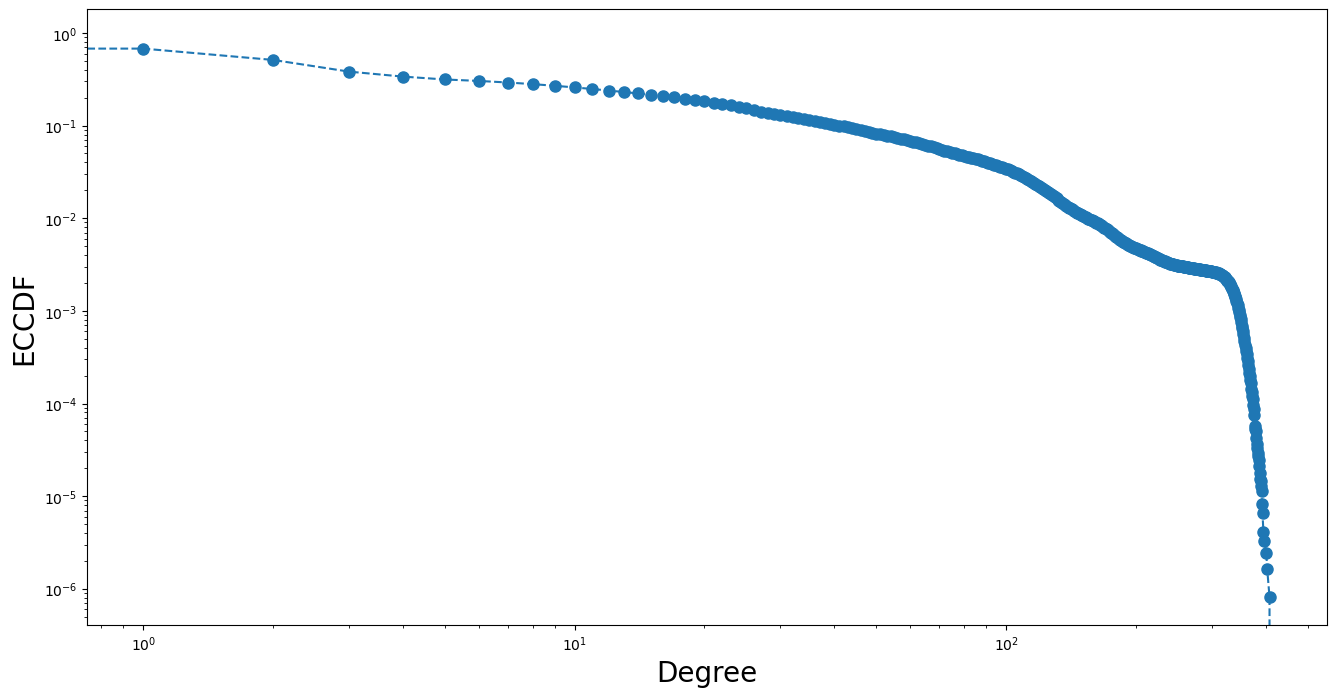

In [25]:
density = nx.density(relabeled)
degree = list(dict(relabeled.degree()).values())
#ECCDF in loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)
plt.show()

In [22]:
Gcc = sorted(nx.connected_components(relabeled), key=len, reverse=True)
G0 = relabeled.subgraph(Gcc[0])
G1 = relabeled.subgraph(Gcc[1])
print(len(G0))
print(len(G1))

781979
221


In [26]:
agedistrib_g1 = []
a1 = 0
a2 = 0
a3 = 0
for i in relabeled.nodes():
    if relabeled.nodes[i]['age'] == '65+':
        a3 += 1
    elif relabeled.nodes[i]['age'] == '20-64':
        a2 += 1
    else: 
        a1 +=1
print("Disribuzione di età su grafo totale")
print("Giovani:",a1,"Attivi:",a2,"Anziani:",a3)
print()
g1 = a1
g2 = a2
g3 = a3
for i in G0.nodes():
    if G0.nodes[i]['age'] == '65+':
        a3 -= 1
    elif G0.nodes[i]['age'] == '20-64':
        a2 -= 1
    else: 
        a1 -=1
print("Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)")
print("Giovani:",a1,"(",round((a1/g1)*100,3),")","Attivi:",a2,"(",round((a2/g2)*100,3),")","Anziani:",a3,"(",round((a3/g3)*100,3),")")
print()
print("Nodi appartenenti alla Giant Component")
print("Giovani:",g1-a1,"Attivi:",g2-a2,"Anziani:",g3-a3)

Disribuzione di età su grafo totale
Giovani: 203686 Attivi: 720971 Anziani: 305337

Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)
Giovani: 9012 ( 4.424 ) Attivi: 147077 ( 20.4 ) Anziani: 291926 ( 95.608 )

Nodi appartenenti alla Giant Component
Giovani: 194674 Attivi: 573894 Anziani: 13411


Mean percentual of workers for sez: 49.553151105128734


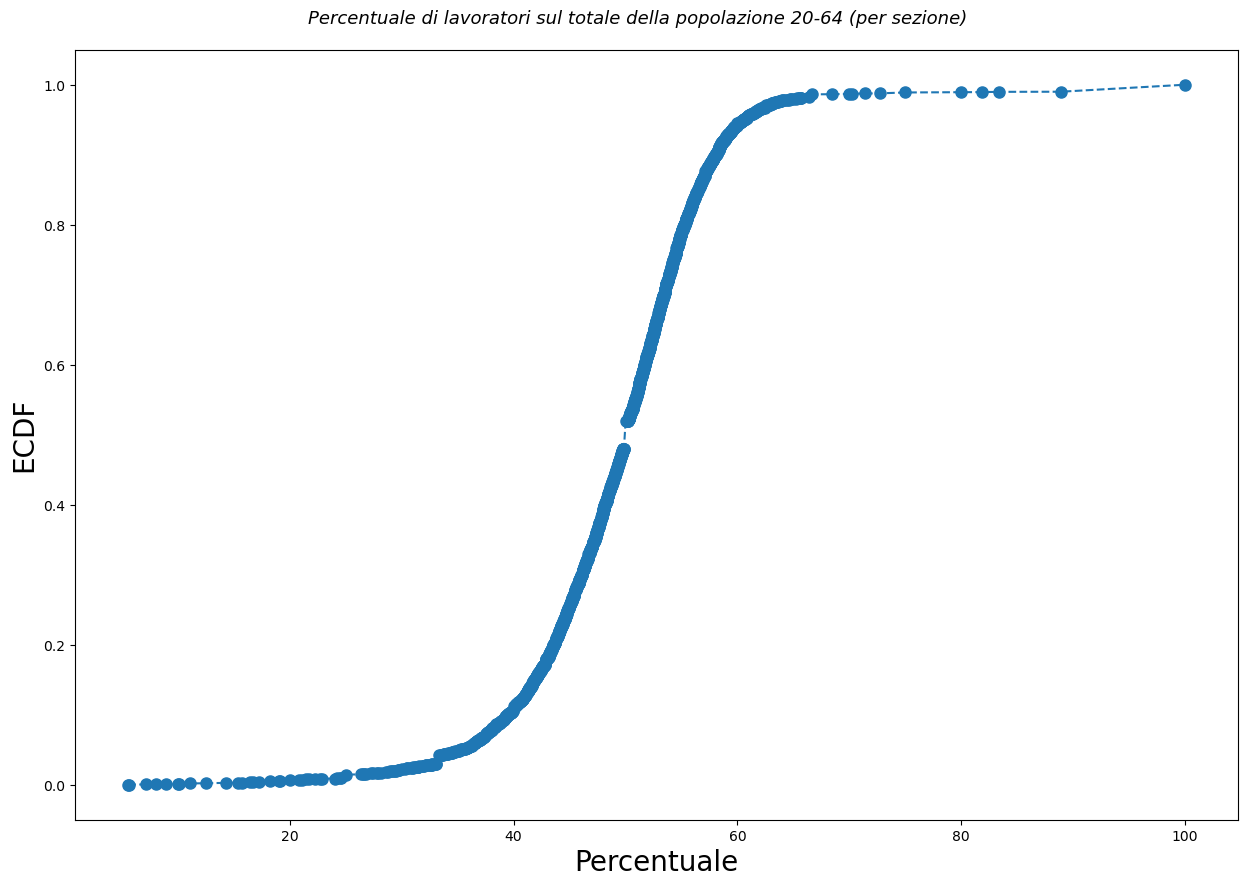

In [24]:
client = MongoClient('localhost', 27017)
db = client['tesi']
db_sezioni = db['sezioni']
db_lavoro = db['lavoro']

work_dist = []
for i in list(db_sezioni.find()):
    #print("Indexing sez:",i["properties"]["SEZ"], end="\r", flush=True)
    num_attivi = 0
    num_workers = 0
    if "famiglie" in i.keys():
        for fam in i["famiglie"]:
            for mem in fam["members"]:
                if mem["age"] == "20-64": 
                    num_attivi += 1
                    if "sez_lavoro" in mem.keys(): num_workers += 1
        if (num_workers != 0 and num_attivi != 0):
            work_dist.append({"sez":i["properties"]["SEZ"],"num":(num_workers/num_attivi)*100})

list_dist =  [i["num"] for i in work_dist]
print("Mean percentual of workers for sez:",np.mean(list_dist))

# ECDF linear scale
plt.style.use('default')
cdf = ECDF(list_dist)
x = np.unique(list_dist)
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=8,  linestyle='--')
# general title
plt.suptitle('Percentuale di lavoratori sul totale della popolazione 20-64 (per sezione)', fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
axes.set_xlabel('Percentuale',size=20)
axes.set_ylabel('ECDF', size = 20)
plt.show()

In [2]:
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")
# Model selection
model = SEIR_ASModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
cfg.add_model_parameter('alpha', 0.2) #Latent period
cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

#This parameter "smoothens" out the infection rate in the first iterations.
#1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
#0: beta*(average_infected_weight)
cfg.add_model_parameter('tp_rate', 0)

cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
model.set_initial_status(cfg)

#Run 50 simulations, results will be a mean of all data generated
simulations = []
for i in range (0,5):
    print("Running simulation number",i+1)
    simulations.append(model.iteration_bunch(60,progress_bar=True))
    model.reset()

Simulating...
100%|██████████| 60/60 [04:24<00:00,  4.41s/it]


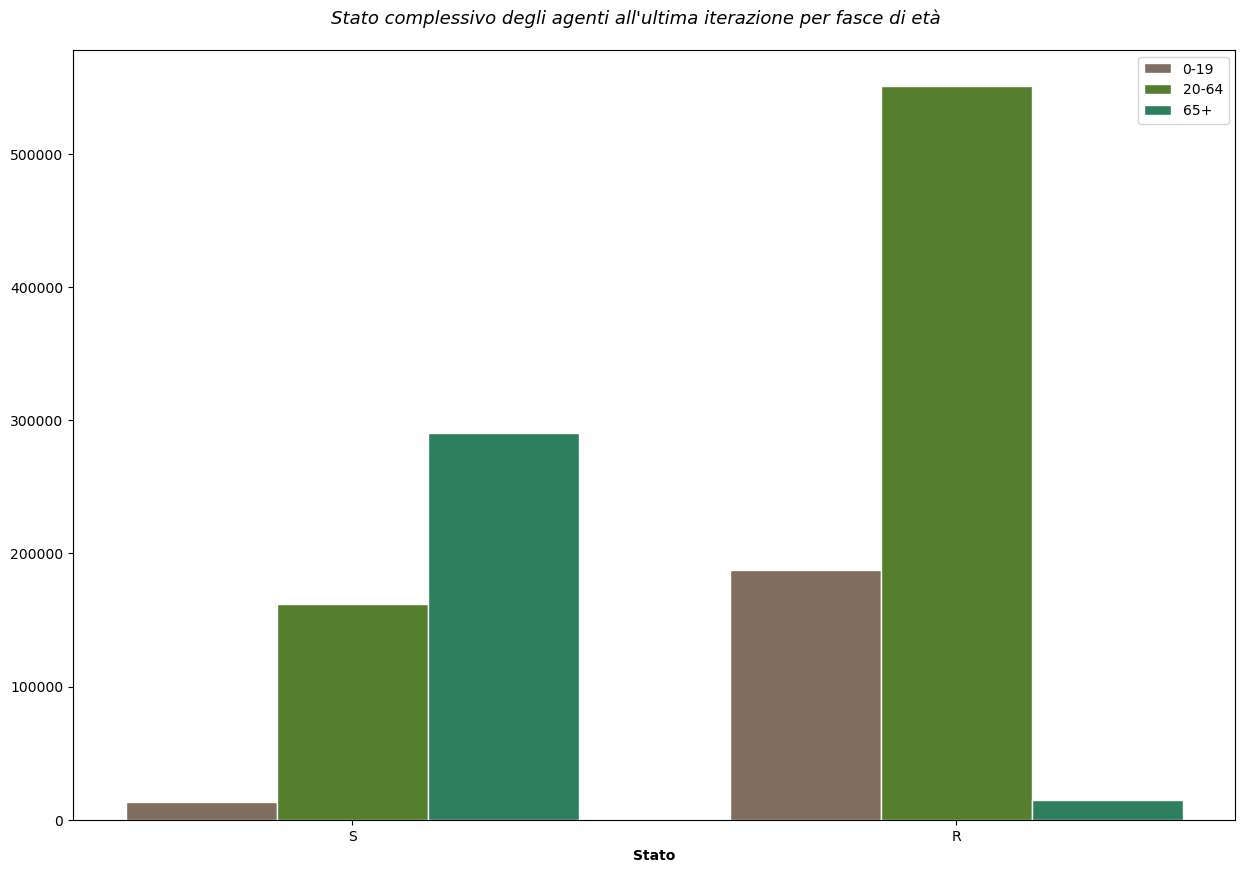


Mean values
[13018.0, 187618.8] [161966.0, 550619.6] [290091.0, 15008.4]

CI 95%
Giovani (S) (12908.444698730142, 13127.555301269858)
Giovani (R) (187444.76007164488, 187792.8399283551)
Attivi (S) (161532.55521215667, 162399.44478784333)
Attivi (R) (550103.6280232843, 551135.5719767157)
Anziani (S) (290014.6250466163, 290167.3749533837)
Anziani (R) (14940.41620304484, 15076.383796955159)


In [27]:
#Create complete status map by dymanically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes
s_giovani = []
r_giovani = []
s_attivi = []
r_attivi = []
s_anziani = []
r_anziani = []

for iteration in simulations:
    graph_stat = {}
    for x in iteration[0]['status']:
        graph_stat[x] = iteration[0]['status'][x]
    for iter in iteration:
        for s in iter['status']:
            graph_stat[s] = iter['status'][s]    

    stats_giovani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_attivi = {0:[],1:[],2:[],3:[],4:[],5:[]}
    stats_anziani = {0:[],1:[],2:[],3:[],4:[],5:[]}
    for i in graph_stat:
        if relabeled.nodes[i]['age'] == '65+':
            stats_anziani[graph_stat[i]].append(i)
        elif relabeled.nodes[i]['age'] == '20-64':
            stats_attivi[graph_stat[i]].append(i)
        else:
            stats_giovani[graph_stat[i]].append(i)
            
    giovani_p = []
    attivi_p = []
    anziani_p = []
    for i in stats_giovani:
        giovani_p.append(len(stats_giovani[i]))
        attivi_p.append(len(stats_attivi[i]))
        anziani_p.append(len(stats_anziani[i]))
    
    #Build mean for CI(95%)
    s_giovani.append(giovani_p[0])
    r_giovani.append(giovani_p[5])
    s_attivi.append(attivi_p[0])
    r_attivi.append(attivi_p[5])
    s_anziani.append(anziani_p[0])
    r_anziani.append(anziani_p[5])

giovani_p = [np.mean(s_giovani),np.mean(r_giovani)]
attivi_p = [np.mean(s_attivi),np.mean(r_attivi)]
anziani_p = [np.mean(s_anziani),np.mean(r_anziani)]

plt.rcParams['figure.figsize'] = [15, 10]

# set width of bar
barWidth = 0.25

# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

# Add xticks on the middle of the group bars
# general title
plt.suptitle("Stato complessivo degli agenti all'ultima iterazione per fasce di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
plt.xlabel('Stato', fontweight='bold')
labels = ['S',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)
 
# Create legend & Show graphic
plt.legend()
plt.show()
print()
print("Mean values")
print(giovani_p,attivi_p,anziani_p)
print()
print("CI 95%")
print("Giovani (S)",st.t.interval(alpha=0.95, df=len(s_giovani)-1, loc=np.mean(s_giovani), scale=st.sem(s_giovani)))
print("Giovani (R)",st.t.interval(alpha=0.95, df=len(r_giovani)-1, loc=np.mean(r_giovani), scale=st.sem(r_giovani)))
print("Attivi (S)",st.t.interval(alpha=0.95, df=len(s_attivi)-1, loc=np.mean(s_attivi), scale=st.sem(s_attivi)))
print("Attivi (R)",st.t.interval(alpha=0.95, df=len(r_attivi)-1, loc=np.mean(r_attivi), scale=st.sem(r_attivi)))
print("Anziani (S)",st.t.interval(alpha=0.95, df=len(s_anziani)-1, loc=np.mean(s_anziani), scale=st.sem(s_anziani)))
print("Anziani (R)",st.t.interval(alpha=0.95, df=len(r_anziani)-1, loc=np.mean(r_anziani), scale=st.sem(r_anziani)))

In [ ]:
#TODO: Check if herd immunity has ben achieved inside the giant component G0
G0_susceptible = []
for i in G0.nodes():
    if i in graph_stat.keys():
        if graph_stat[i] == 0:
            G0_susceptible.append(i)
print("Nodi in stato S all'ultima iterazione:",len(G0_susceptible))
print()

neighbors = {}
for i in G0_susceptible:
    neighborhood = [n for n in relabeled.neighbors(i)]
    for n in neighborhood:
        neighbors[n] = graph_stat[n]
print("Numero di neighbors dei nodi con stato S all'ultima iterazione:",len(neighbors))
print()

NS = 0
NIE = 0
NR = 0
for i in neighbors:
    if neighbors[i] == 0: NS += 1
    elif neighbors[i] == 5: NR += 1
    else: NIE +=1
        
print("S:",NS,"R:",NR,"EAS/IAS:",NIE)

In [ ]:
neighbors_s = {}
neighbors_r = {}
for i in G0_susceptible:
    neighborhood = [n for n in relabeled.neighbors(i)]
    neighbors_s[i] = []
    neighbors_r[i] = []
    sum = 0
    sus = 0
    rem = 0
    for n in neighborhood:
        sum += 1
        if graph_stat[n] == 0: sus += 1
        if graph_stat[n] == 5: rem += 1
    neighbors_s[i].append((sus/sum)*100)
    neighbors_r[i].append((rem/sum)*100)
    
neighbors_s = [n[0] for n in neighbors_s.values()]
neighbors_r = [n[0] for n in neighbors_r.values()]

# ECDF linear scale
plt.style.use('default')
cdf = ECDF(neighbors_s)
x = np.unique(neighbors_s)
y = cdf(x)
fig_cdf = plt.figure(figsize=(15,10))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='--', label='Percentuale di S')
cdf = ECDF(neighbors_r)
x = np.unique(neighbors_r)
y = cdf(x)
axes.plot(x,y,marker='o',ms=6, linestyle='--', label='Percentuale di R')
# general title
plt.suptitle('Composizione del neighbourhood dei nodi con stato S all ultima iterazione (in percentuale)', fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
axes.set_xlabel('Percentuale',size=20)
axes.set_ylabel('ECDF', size = 20)
axes.legend()
plt.show()

In [ ]:
df=pd.DataFrame({'S':neighbors_s,'R':neighbors_r})

#Style
palette = plt.get_cmap('Set1')
plt.style.use('seaborn-darkgrid')

#Hist only
plt.figure(figsize=(15,10))
s = sns.histplot(df["R"], kde=False, color=palette(0), label="Susceptible")
r = sns.histplot(df["S"], kde=False, color=palette(1), label="Removed")
s.set(xlabel='Percentuale', ylabel='Individui')
plt.legend()
plt.show()

plt.figure(figsize=(15,10))
plt.hist([df["S"], df["R"]], color=[palette(0),palette(1)], label=["Susceptible","Removed"])
plt.legend()
plt.xlabel("Percentuale")
plt.ylabel("Individui")
plt.show()


f, axes = plt.subplots(1, 2, figsize=(15, 10), sharex=True)
s = sns.histplot(df["R"], ax=axes[0], color=palette(0))
r = sns.histplot(df["S"], ax=axes[1], color=palette(1))
s.set(xlabel='Percentuale', ylabel='Individui')
r.set(xlabel='Percentual', ylabel='Individui')
plt.show()

In [ ]:
#TODO: Create a dict with "iteration":"newly infected individuals"
graph_stat = {}
for i in iterations[0]['status']:
    graph_stat[i] = iterations[0]['status'][i]

giovani_a = {}
giovani_s = {}
attivi_a = {}
attivi_s = {}
anziani_a = {}
anziani_s = {}

for iter in iterations:
    inc_1a = 0
    inc_1s = 0
    inc_2a = 0
    inc_2s = 0
    inc_3a = 0
    inc_3s = 0
    for s in iter['status']:
        if graph_stat[s] == 0 or graph_stat[s] == 1 or graph_stat[s] == 2:
            if iter['status'][s] == 3:
                if relabeled.nodes[s]['age'] == '20-64':
                    inc_2a += 1
                elif relabeled.nodes[s]['age'] == '65+':
                    inc_3a += 1
                else: 
                    inc_1a += 1
            elif iter['status'][s] == 4:
                if relabeled.nodes[s]['age'] == '20-64':
                    inc_2s += 1
                elif relabeled.nodes[s]['age'] == '65+':
                    inc_3s += 1
                else: 
                    inc_1s += 1
    giovani_a[iter['iteration']] = inc_1a
    giovani_s[iter['iteration']] = inc_1s
    attivi_a[iter['iteration']] = inc_2a
    attivi_s[iter['iteration']] = inc_2a
    anziani_a[iter['iteration']] = inc_3a
    anziani_s[iter['iteration']] = inc_3s

In [ ]:
# Make a data frame
df=pd.DataFrame({'x': range(1,len(iterations)+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'Giovani Sintomatici':list(giovani_s.values()),'Attivi Asintomatici':list(attivi_a.values()),
                 'Attivi Sintomatici':list(attivi_s.values()),'Anziani Asintomatici':list(anziani_a.values()),
                 'Anziani Sintomatici':list(anziani_s.values())})

# style
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))
 
# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=1, alpha=0.9, label=column)


#Add legend
plt.legend()
 
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
    
#Add titles
plt.xlabel("Time")
plt.ylabel("Score")
plt.show()

In [ ]:
# Make a data frame
df=pd.DataFrame({'x': range(1,len(iterations)+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'Giovani Sintomatici':list(giovani_s.values()),'Attivi Asintomatici':list(attivi_a.values()),
                 'Attivi Sintomatici':list(attivi_s.values()),'Anziani Asintomatici':list(anziani_a.values()),
                 'Anziani Sintomatici':list(anziani_s.values())})

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
 
    # Find the right spot on the plot
    plt.subplot(2,3, num)
    
    # plot every groups, but discreet
    for v in df.drop('x', axis=1):
        plt.plot(df['x'], df[v], marker='', color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.plot(df['x'], df[column], marker='', color=palette(num), linewidth=2, alpha=0.9, label=column)
 
    # Same limits for everybody!
    plt.xlim(0,61)
    plt.ylim(0,25000)
 
    # Not ticks everywhere
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
 
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.98)
 
# Axis title
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')
plt.show()

In [ ]:
# library
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
 
# Your x and y axis
x=range(1,len(iterations)+1)
y=[list(giovani_a.values()),list(giovani_s.values()),list(attivi_a.values()),list(attivi_s.values()),list(anziani_a.values()),list(anziani_s.values())]
 
# use a known color palette (see..)
plt.style.use('seaborn-darkgrid')
pal = sns.color_palette("Set1")
plt.figure(figsize=(15,10))
plt.stackplot(x,y, labels=['Giovani Asintomatici','Giovani Sintomatici','Attivi Asintomatici','Attivi Sintomatici','Anziani Asintomatici','Anziani Sintomatici'], colors=pal, alpha=0.4 )
plt.legend(loc='upper right')
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.92)
plt.show()
 

In [ ]:
# Make a data frame
df=pd.DataFrame({'x': range(1,len(iterations)+1),'Giovani Asintomatici':list(giovani_a.values()),
                 'Giovani Sintomatici':list(giovani_s.values()),'Attivi Asintomatici':list(attivi_a.values()),
                 'Attivi Sintomatici':list(attivi_s.values()),'Anziani Asintomatici':list(anziani_a.values()),
                 'Anziani Sintomatici':list(anziani_s.values())})

# Initialize the figure
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,10))

# create a color palette
palette = plt.get_cmap('Set1')
 
# multiple line plot
num=0
for column in df.drop('x', axis=1):
    num+=1
    
    # Your x and y axis
    x=range(1,len(iterations)+1)
    y=[list(giovani_a.values()),list(giovani_s.values()),list(attivi_a.values()),list(attivi_s.values()),list(anziani_a.values()),list(anziani_s.values())]
 
    # Find the right spot on the plot
    plt.subplot(2,3, num)
    
    # plot every groups, but discreet
    for v in df.drop('x', axis=1):
        plt.stackplot(df['x'], df[v], color='grey', linewidth=0.6, alpha=0.3)
 
    # Plot the lineplot
    plt.stackplot(df['x'], df[column], color=palette(num), linewidth=2, alpha=0.9)
 
    # Same limits for everybody!
    plt.xlim(0,61)
    plt.ylim(0,25000)
 
    # Not ticks everywhere
    if num in range(7) :
        plt.tick_params(labelbottom='off')
    if num not in [1,4,7] :
        plt.tick_params(labelleft='off')
 
    # Add title
    plt.title(column, loc='left', fontsize=12, fontweight=0, color=palette(num) )
 
# general title
plt.suptitle("Andamento dell'infezione A/S per fascia di età", fontsize=13, fontweight=0, color='black', style='italic', y=0.98)
 
# Axis title
plt.text(0.5, 0.02, 'Time', ha='center', va='center')
plt.text(0.06, 0.5, 'Note', ha='center', va='center', rotation='vertical')
plt.show()